In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras 
import tensorflow as tf

In [41]:
# Load the IPL dataset
df = pd.read_csv('ipl_data.csv')
df.sample(10)

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
28754,233,2011-05-21,Himachal Pradesh Cricket Association Stadium,Deccan Chargers,Kings XI Punjab,S Dhawan,R McLaren,90,0,10.2,38,0,49,27,198
63336,515,2016-04-18,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Sunrisers Hyderabad,RG Sharma,Bipul Sharma,43,3,7.1,32,2,23,5,142
72054,585,2017-04-23,Saurashtra Cricket Association Stadium,Kings XI Punjab,Gujarat Lions,GJ Maxwell,RA Jadeja,107,2,12.3,44,1,57,14,188
42292,343,2013-04-23,M Chinnaswamy Stadium,Royal Challengers Bangalore,Pune Warriors,TM Dilshan,IC Pandey,132,0,10.1,71,0,105,23,263
37413,303,2012-05-17,Himachal Pradesh Cricket Association Stadium,Chennai Super Kings,Kings XI Punjab,S Anirudha,RJ Harris,119,6,19.4,43,2,48,1,120
14136,115,2010-03-14,"MA Chidambaram Stadium, Chepauk",Deccan Chargers,Chennai Super Kings,HH Gibbs,R Ashwin,66,2,8.4,17,2,7,2,190
18354,149,2010-04-07,Eden Gardens,Kolkata Knight Riders,Delhi Daredevils,SC Ganguly,MF Maharoof,28,0,2.4,28,0,25,2,181
61928,503,2015-05-24,Eden Gardens,Mumbai Indians,Chennai Super Kings,KA Pollard,MM Sharma,184,3,18.1,59,0,36,28,202
54737,445,2014-05-27,Eden Gardens,Kolkata Knight Riders,Kings XI Punjab,RV Uthappa,P Awana,2,0,0.6,2,0,1,1,163
54394,442,2014-05-24,Eden Gardens,Sunrisers Hyderabad,Kolkata Knight Riders,S Dhawan,R Vinay Kumar,28,1,3.1,28,1,10,4,160


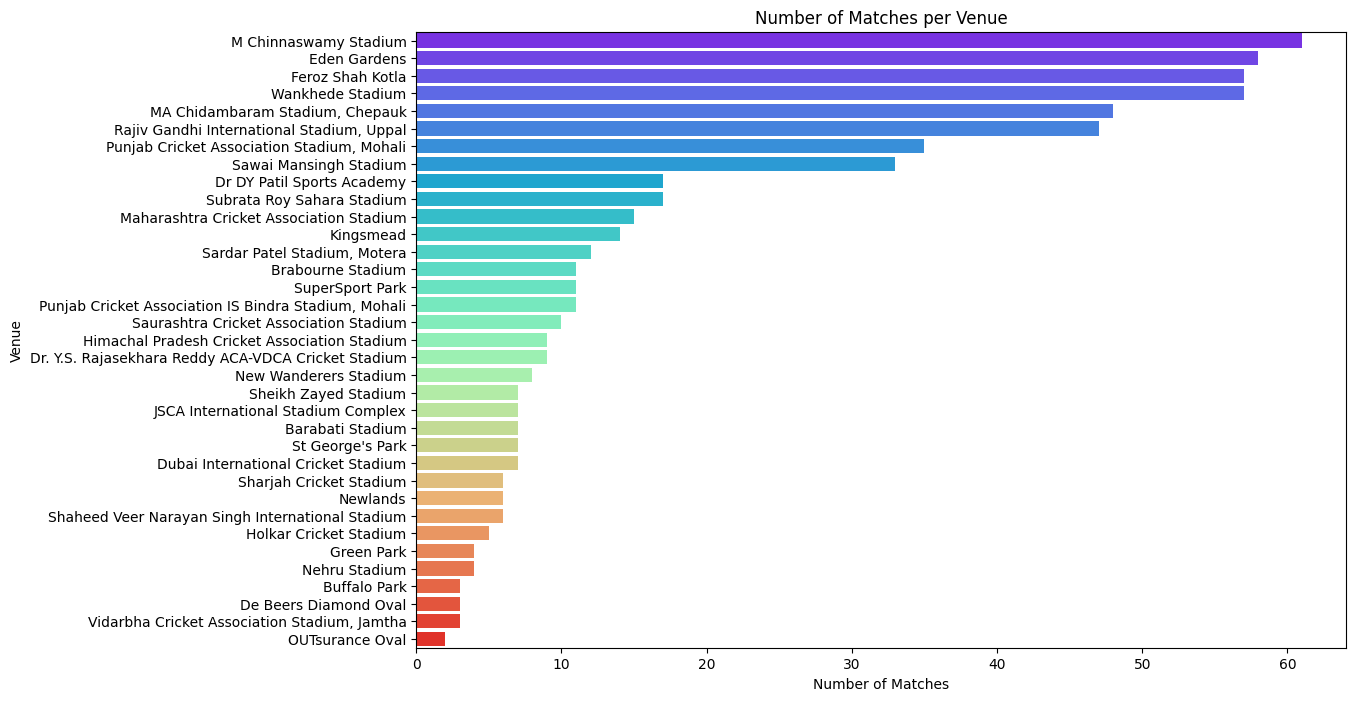

In [42]:
# Visualizing the number of matches played at each venue
data = df.copy()
matches_per_venue = data[['mid', 'venue']].drop_duplicates()
matches_count = matches_per_venue['venue'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=matches_count.values, y=matches_count.index, palette="rainbow")
plt.title('Number of Matches per Venue')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.show()

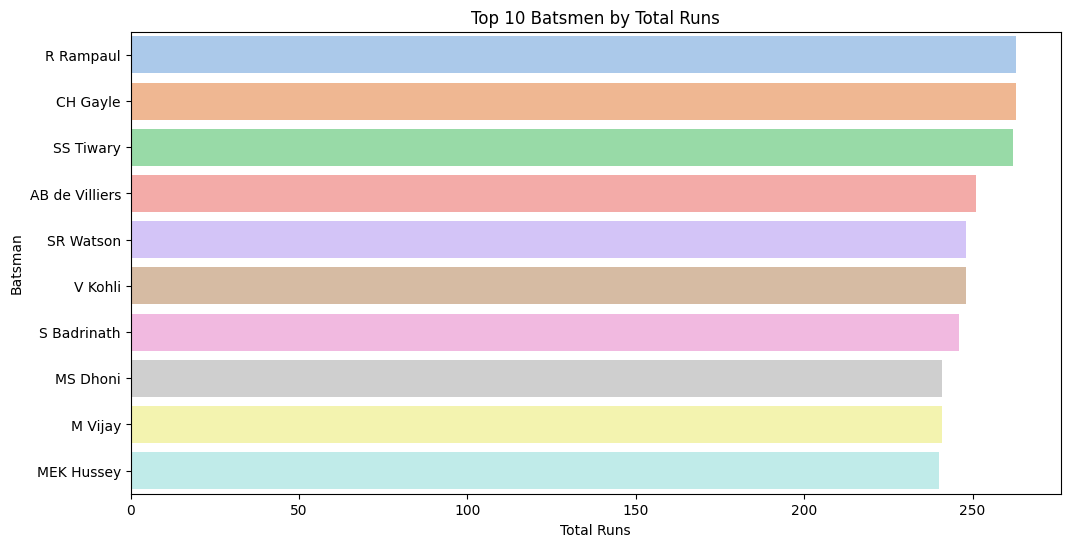

In [43]:
# Visualizing the top 10 batsmen by total runs
runs_by_batsman = data.groupby('batsman')['runs'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=runs_by_batsman.values, y=runs_by_batsman.index,palette="pastel")
plt.title('Top 10 Batsmen by Total Runs')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.show()

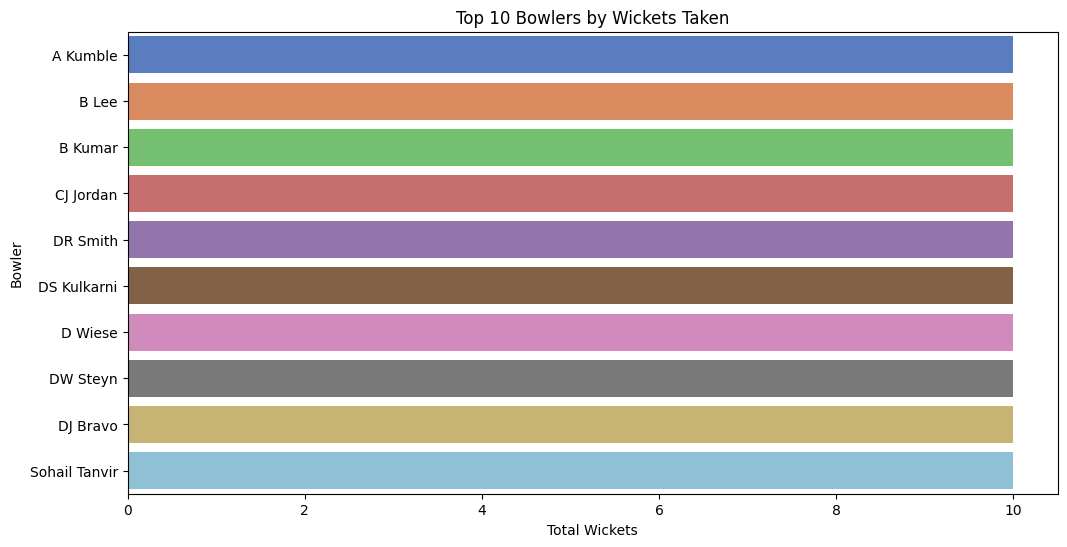

In [44]:
# Visualizing the top 10 bowlers by total wickets
wickets_by_bowler = data.groupby(
    'bowler')['wickets'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=wickets_by_bowler.values,
            y=wickets_by_bowler.index, palette="muted")
plt.title('Top 10 Bowlers by Wickets Taken')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.show()

In [45]:
from sklearn.preprocessing import LabelEncoder
# Encoding categorical variables using Label Encoding
cat_cols = ['bat_team', 'bowl_team', 'venue', "batsman", "bowler"]

data_encoded = data.copy()

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le

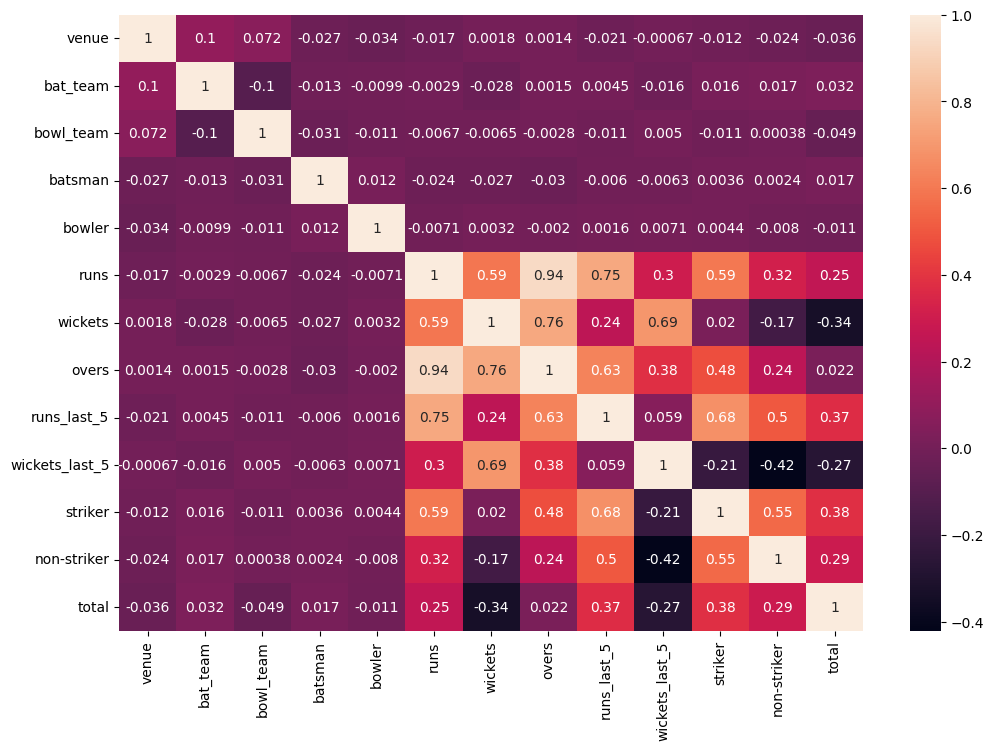

In [46]:
# Feature Correlation Analysis using Heatmap
plt.figure(figsize=(12, 8))
data_corr = data_encoded.drop(columns=["date", "mid"], axis=1)
sns.heatmap(data_corr.corr(), annot=True)
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
# Feature Selection and Train-Test Split

feature_cols = ['bat_team', 'bowl_team', 'venue', 'runs',                 
                'wickets', 'overs', 'striker', 'batsman', 'bowler']             

X = data_encoded[feature_cols]
y = data_encoded['total']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [48]:
from sklearn.preprocessing import MinMaxScaler
# Feature Scaling using Min-Max Scaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Building the Deep Learning Model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

huber_loss = tf.keras.losses.Huber(delta=1.0)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=huber_loss
)

# Training the Model with Early Stopping
history = model.fit(
    X_train_scaled, y_train,
    epochs=150,              # keep large, early stopping will handle it
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping]
)

Epoch 1/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 26.0510 - val_loss: 15.3403
Epoch 2/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.9269 - val_loss: 14.9156
Epoch 3/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.7465 - val_loss: 14.3777
Epoch 4/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.7018 - val_loss: 14.4393
Epoch 5/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.6508 - val_loss: 14.6252
Epoch 6/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.6532 - val_loss: 14.3130
Epoch 7/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.5896 - val_loss: 14.2822
Epoch 8/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.5951 - val_loss: 14.2620
Epoch 9/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.5567 - val_loss: 14.1579
Epoch 10/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.5453 - val_loss: 14.1134
Epoch 11/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.5008 - val_loss: 14.1570
Epoch 12/150
832/83

<Axes: >

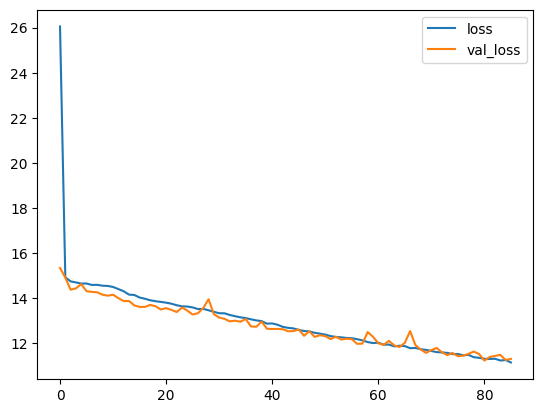

In [50]:
# Visualizing Model Losses
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

In [53]:
# Save the trained model
model.save("ipl_score_prediction_model.h5")


In [54]:
from tensorflow.keras.models import load_model

model = load_model("ipl_score_prediction_model.h5")


In [51]:
# Evaluating Model Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(X_test_scaled)

mean_absolute_error(y_test, predictions)

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step


11.723596572875977

In [52]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

venue = widgets.Dropdown(options=list(
    label_encoders['venue'].classes_), description='Select Venue:')
venue.style = {'description_width': 'initial'}

batting_team = widgets.Dropdown(options=list(
    label_encoders['bat_team'].classes_), description='Select Batting Team:')
batting_team.style = {'description_width': 'initial'}

bowling_team = widgets.Dropdown(options=list(
    label_encoders['bowl_team'].classes_), description='Select Bowling Team:')
bowling_team.style = {'description_width': 'initial'}

striker = widgets.Dropdown(options=list(
    label_encoders['batsman'].classes_), description='Select Striker:')
striker.style = {'description_width': 'initial'}

bowler = widgets.Dropdown(options=list(
    label_encoders['bowler'].classes_), description='Select Bowler:')
bowler.style = {'description_width': 'initial'}

runs = widgets.IntText(value=0, description='Runs:', style={
                       'description_width': 'initial'})
wickets = widgets.IntText(value=0, description='Wickets:', style={
                          'description_width': 'initial'})
overs = widgets.FloatText(value=0.0, description='Overs:', style={
                          'description_width': 'initial'})
striker_ind = widgets.IntText(value=0, description='Striker:', style={
                              'description_width': 'initial'})  # Assuming 0 or 1
predict_button = widgets.Button(description="Predict Score")

output = widgets.Output()


def predict_score(b):
    with output:
        clear_output()  # Clear previous output

        encoded_venue = label_encoders['venue'].transform([venue.value])[0]
        encoded_batting_team = label_encoders['bat_team'].transform(
            [batting_team.value])[0]
        encoded_bowling_team = label_encoders['bowl_team'].transform(
            [bowling_team.value])[0]
        encoded_striker = label_encoders['batsman'].transform([striker.value])[
            0]
        encoded_bowler = label_encoders['bowler'].transform([bowler.value])[0]

        input_features = [
            encoded_batting_team,
            encoded_bowling_team,
            encoded_venue,
            runs.value,
            wickets.value,
            overs.value,
            striker_ind.value,
            encoded_striker,
            encoded_bowler
        ]

        input_array = np.array(input_features).reshape(1, -1)
        input_array = scaler.transform(input_array)
        predicted_score = model.predict(input_array)

        print(f"Predicted Total Runs: {int(predicted_score[0])}")


predict_button.on_click(predict_score)

display(venue, batting_team, bowling_team, striker, bowler,
        runs, wickets, overs,
        striker_ind,
        predict_button, output)

Dropdown(description='Select Venue:', options=('Barabati Stadium', 'Brabourne Stadium', 'Buffalo Park', 'De Be…

Dropdown(description='Select Batting Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Bowling Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Striker:', options=('A Ashish Reddy', 'A Chandila', 'A Chopra', 'A Choudhary', 'A…

Dropdown(description='Select Bowler:', options=('A Ashish Reddy', 'A Chandila', 'A Choudhary', 'A Flintoff', '…

IntText(value=0, description='Runs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Wickets:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Overs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Striker:', style=DescriptionStyle(description_width='initial'))

Button(description='Predict Score', style=ButtonStyle())

Output()